In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

In [2]:
ds1 = pd.read_csv('chem.tsv', delimiter = '\t') 
drug_bank = list(ds1['#Drug'])
gene_uniprot = list(ds1['Gene'])

In [5]:
G1 = nx.read_edgelist('chem.tsv', delimiter='\t') 

In [6]:
degrees_G1 = G1.degree()
num = list()
g_nodes = list()
for i in degrees_G1:
    if(i[0][0]!= 'D'): #taking genes only
        g_nodes.append(i[0])
        num.append(int(i[1]))
    


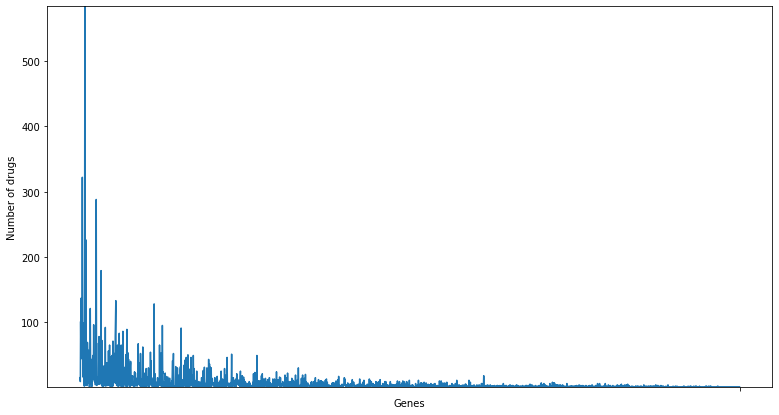

In [7]:
plt.figure(figsize=(13,7))
plt.ylabel('Number of drugs')
plt.ylim([np.min(num), np.max(num)])
plt.xlabel('Genes')
plt.plot(g_nodes, num)
plt.xticks('')
plt.savefig('dist_ds1.png')
plt.show()

Train and test sets of positive and negative samples with label 1 or 0 respectively

In [9]:
num_of_removed = [int(len(drug_bank)*0.25)]
print(num_of_removed)

In [11]:
negative_edges_graph1 = list()
while len(negative_edges_graph1) < len(list(G1.edges)):
    random_drug = random.choice(drug_bank)
    random_gene = random.choice(gene_uniprot)
    try: 
        sh_path = nx.shortest_path_length(G1,source=random_drug,target=random_gene)
    except: 
        sh_path = 3
    if G1.has_edge(random_drug, random_gene) == False and sh_path > 2:
        negative_edges_graph1.append([random_drug, random_gene])


'\nnegative_edges_graph2 = list()\nwhile len(negative_edges_graph2) < len(list(G2.edges)):\n    random_drug = random.choice(drug_cid)\n    random_gene = random.choice(gene_entrez)\n    try: \n        sh_path = nx.shortest_path_length(G2,source=random_drug,target=random_gene)\n    except: \n        sh_path = 3\n    if G1.has_edge(random_drug, random_gene) == False and sh_path > 2:\n        negative_edges_graph2.append([random_drug, random_gene])\n'

In [12]:
edges_g1 = list(G1.edges)
removed_g1 = list()
while len(removed_g1) < num_of_removed[0]:
    to_be_removed = random.choice(edges_g1)
    if degrees_G1[to_be_removed[0]] > 1:
        G1.remove_edge(to_be_removed[0], to_be_removed[1]) 
        edges_g1.remove(to_be_removed)
        removed_g1.append(to_be_removed)
        

In [ ]:
negative_edges_graph1

In [ ]:
list(G1.edges)

In [15]:
G1_train_edges_positive = list(G1.edges)
G1_train_edges_negative = negative_edges_graph1[:len(list(G1.edges))]
G1_test_edges_positive = removed_g1
G1_test_edges_negative = negative_edges_graph1[len(list(G1.edges)):]



'\nG2_train_edges_positive = list(G2.edges)\nG2_train_edges_negative = negative_edges_graph2[:len(list(G2.edges))]\nG2_test_edges_positive = removed_g2\nG2_test_edges_negative = negative_edges_graph2[len(list(G2.edges)):]\n'

# phase3 node2vec

In [16]:
'''
functions to create train and test label according to positive and negative edges
'''
def getposlabel(x):
    l = []
    for i in x:
        l.append(1)
    return l
def getneglabel(x):
    l = []
    for i in x:
        l.append(0)
    return l

In [17]:
train_set = G1_train_edges_positive + G1_train_edges_negative
train_label = getposlabel(G1_train_edges_positive) + getneglabel(G1_train_edges_negative)
print("train set size: "+ str(len(train_set)))
print("train label size: "+ str(len(train_label)))

train set size: 22708
train label size: 22708


In [18]:
test_set = G1_test_edges_positive + G1_test_edges_negative
test_label = getposlabel(G1_test_edges_positive) + getneglabel(G1_test_edges_negative)
print("test set size: "+ str(len(test_set)))
print("test label size: "+ str(len(test_label)))

test set size: 7568
test label size: 7568


In [19]:
#creating graph from new data set = train set + test set
Gdata =nx.convert.from_edgelist(train_set+test_set)


In [20]:
from node2vec import Node2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

Training node2vec model with default parameters.

In [21]:
node2vec = Node2Vec(Gdata)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [06:30<00:00, 39.04s/it]


In [22]:
model = node2vec.fit()

In [23]:
'''
function to get embedding values for train and test set
'''
def embdata(x,embeder):
    l = []
    for i in x:
        l.append(embeder[(i[0], i[1])])
    return l

In [24]:
'''
Function to run logistic regression and print roc score and ap
'''
def runlogreg(trx,trl,tsx,tsl):
    lr= LogisticRegression(class_weight="balanced")
    lr.fit(trx,trl)
    pred=lr.predict_proba(tsx)
    print("roc score: "+ str(roc_auc_score(tsl, pred[:,1])))
    print("average prcision score: "+ str(average_precision_score(tsl, pred[:,1])))

In [25]:
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [31]:
edges_embs[('DB02721', 'P10632')]

array([-2.32427263e+00,  3.50398779e+00, -2.73476362e+00, -1.32783368e-01,
       -1.32339931e+00, -1.78237355e+00,  2.66692162e-01, -2.34073289e-02,
       -1.67679477e+00, -1.24552965e+00, -8.36555362e-01, -1.00563564e+01,
       -3.72379720e-01,  1.32136655e+00,  2.61903167e-01, -2.25979894e-01,
       -3.94987971e-01,  7.48488605e-02, -1.14167905e+00,  8.49578716e-03,
        7.50350133e-02,  2.18664500e-04, -7.64884710e+00, -3.70068145e+00,
       -1.14742196e+00,  1.27518439e+00,  6.73671913e+00, -3.71649671e+00,
        1.86484218e-01,  3.90550852e+00,  1.43319106e-04, -2.41086353e-02,
        5.88399731e-02, -4.08612877e-01,  5.99540114e-01,  4.58671379e+00,
        6.71355724e-02,  2.66794950e-01, -1.30249822e+00,  6.63302839e-01,
        1.36374264e+01,  9.88222003e-01,  6.14303946e-01,  1.16065872e+00,
       -2.96539187e+00, -4.46878344e-01,  2.12071761e-01, -1.57463825e+00,
        1.32590640e+00, -3.27872038e+00, -5.53529561e-02, -1.72084498e+00,
       -1.95832551e+00,  

In [26]:
train_x = embdata(train_set, edges_embs)
test_x = embdata(test_set, edges_embs)

In [93]:
#print(len(test_x))
#print(len(test_label))

7568
7568


In [27]:
print("Evaluation for Hadamard embedder")
runlogreg(train_x, train_label, test_x, test_label)

Evaluation for Hadamard embedder
roc score: 0.613992193122036
average prcision score: 0.6430334475625792


In [28]:
from node2vec.edges import WeightedL1Embedder
edges_embsw1 = WeightedL1Embedder(keyed_vectors=model.wv)

In [ ]:
edges_embsw1[('DB02721', 'P10632')]

In [29]:
ltrain_x = embdata(train_set, edges_embsw1)
ltest_x = embdata(test_set, edges_embsw1)

In [30]:
print("Evaluation for weighted L1 embedder")
runlogreg(ltrain_x,train_label,ltest_x,test_label)

Evaluation for weighted L1 embedder
roc score: 0.608641690952
average prcision score: 0.6091259185610665
